# <center> Organizacion de datos </center>
#### <center> Curso Rodriguez </center>
## <center> Trabajo practico I: Reservas de Hotel </center>
#### <center> Integrantes del grupo: </center>

<center>

| Apellido y nombre | Padron |
| - | - |
| Ayala, Camila | 107440 |
| Loscalzo, Melina | 106571 |
| Masri, Noah | 108814 |

</center>

# Checkpoint 3: Ensambles de modelos

# Preparacion

Comenzamos como siempre, importando las librerias que vamos a usar

In [1]:
import pandas as pd
import numpy as np
import pickle

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from six import StringIO
from IPython.display import Image

#modelos y métricas
import sklearn as sk
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
import plotly.graph_objs as go

En segundo lugar, importamos el dataset con el que vamos a estar trabajando; el dataset ya trabajado en el checkpoint 1

In [2]:
ds = pd.read_csv("https://drive.google.com/uc?export=download&id=1HuOWp-SuBRQrokZkpEWEz2kaloWOJqiR")

Generamos una copia de este para no alterar sus datos originales.

In [3]:
ds_ensambles = ds.copy()

Tal como en la parte anterior, seleccionamos las columnas que no consideramos importantes, y las quitamos. El criterio fue explicado ya en el checkpoint 2.

In [4]:
to_drop = ['country', 'reservation_status_date', 'stays_in_weekend_nights', 'arrival_date_year', 'arrival_date_day_of_month', 'id','assigned_room_type', 'days_in_waiting_list', 'company']
ds_ensambles.drop(to_drop, axis = 'columns', inplace = True)

# Funciones utiles

Para esta entrega se pide realizar una variedad de modelos de prediccion, y para cada uno de ellos, evaluar su performance en los conjuntos de entrenamiento y validación, explicar todas las métricas y mostrar la matriz de confusión. Dado que esto se pide para todos, creamos una funcion que imprima la matriz de confusion y las metricas dado el x e y de un dataset, para poder llamarla con cada modelo tanto para el set de entrenamiento como para el de testeo.

In [5]:
def mostrarPerformance (model, x, y):
  y_pred = model.predict(x)

  cm = confusion_matrix(y,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

  print(classification_report(y,y_pred))
  print('F1-Score: {}'.format(f1_score(y, y_pred, average='binary')))

Creamos otra funcion que separa nuestro dataset en un conjunto de entrenamiento y testeo. No lo hacemos una sola vez generalizado ya que para algunos modelos podrian ser mas o menos relevantes ciertas columnas o habria q hacerle un trabajo previo, mientras que quizas para otros no.

In [6]:
# El test size es un parametro adicional, pero que por defecto tiene asignado 0.3
def separarConjuntos(ds_ensambles, test_size=0.3): 
    
    # Creo un dataset con los features que voy a usar para clasificar
    ds_ensambles_x = ds_ensambles.drop(['is_canceled'], axis='columns', inplace=False)

    # Creo un dataset con la variable target
    ds_ensambles_y = ds_ensambles['is_canceled'].copy()

    # Genero los conjuntos de train y de test
    return train_test_split(ds_ensambles_x, ds_ensambles_y, test_size=test_size, random_state=2)


## para llamarla x_train, x_test, y_train, y_test = separarConjuntos(ds, test_size)

Luego, otra funcion que busca optimizar los hiperparametros usando Kfolds Randomized Cross Validation, ya que lo necesitamos en mas de uno, por lo que es util tenerlo modularizado. Esta funcion devuelve el modelo con los mejores hiperparametros hallados ya entrenado.

In [7]:
def buscarMejoresHiperparametros(n, folds, model, parametres, x_train, y_train, metric= make_scorer(sk.metrics.f1_score)) :
  
  kfoldcv = StratifiedKFold(n_splits=folds)
  randomcv = RandomizedSearchCV(estimator=model,
                              param_distributions = parametres,
                              scoring=metric,
                              cv=kfoldcv,
                              n_iter=n, 
                              random_state=42) #plantamos la semilla para que nos den siempre los mismos hiperparametros

  #Entrenamos al random search
  randomcv.fit(X = x_train, y = y_train)

  best_params = randomcv.best_params_
  best_score = randomcv.best_score_

  print(f"Best parameters: {best_params}")
  print(f"Best score: {best_score}")

  best_model = model.set_params(**best_params)
  best_model.fit(x_train, y_train)

  return best_model

Esta otra funcion realiza el hot-encoding que usamos para deshacernos de variables categoricas, lo cual es necesario para realizar algunos modelos.
Aplicamos a algunas esto, mientras que a otras que no nos 
resultan tan relevantes las mapeamos a diversos valores. Resulta natural el mapeo del tipo de habitacion pues habiamos notado un patron de orden en los precios.

In [8]:
def ds_con_one_hot_encoding(ds):
  ds = pd.get_dummies(ds, columns=["hotel","deposit_type","customer_type", "market_segment"], drop_first=True)

  ds['meal'] = ds['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

  ds['distribution_channel'] = ds['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                        'GDS': 4})

  ds['reserved_room_type'] = ds['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
                                                                    'H': 7, 'L': 8, 'P':9})

  ds['agent'] = ds['agent'].replace('No_agent', 0)
  ds['agent'] = ds['agent'].astype(float)

  return ds

# a. Clasificador KNN optimizando parametros con K-Fold Cross Validation

Para comenzar el análisis, primero nos deshacemos de las variables categoricas utilizando nuestra función de one hot encoding.

In [ ]:
ds_reservas_kNN = ds_con_one_hot_encoding(ds_ensambles)

Aplicamos nuestra función separarConjuntos, para separar el dataset en entrenamiento y testeo. En este caso consideramos mas conveniente usar unicamente un 20% de los datos como datos de testeo

In [ ]:
x_train, x_test, y_train, y_test = separarConjuntos(ds_reservas_kNN,0.2)

Comenzamos creando un modelo base, para poder optimizarlo

In [ ]:
KNN_Classifier = KNeighborsClassifier()

Obtenemos sus parametros para ver cuales son los que vienen por defecto.

In [ ]:
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


Veamos que ocurre al variar la cantidad de vecinos usando Cross-Validation

In [ ]:
k_range=range(1,30) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='accuracy')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

KeyboardInterrupt: ignored

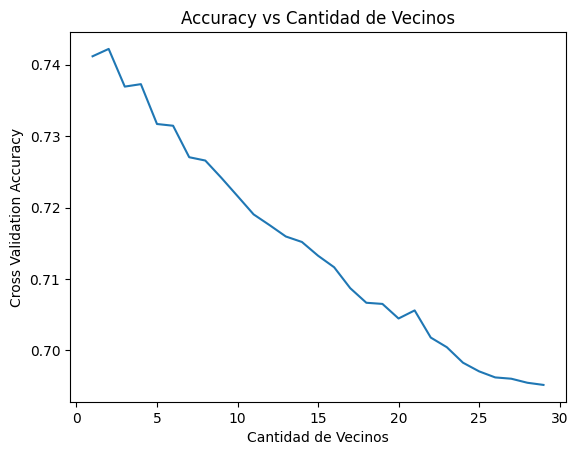

In [ ]:
#ploteamos accuracy vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

Ahora, buscaremos optimizar los hiperparametros por medio de random search. Entre los parametros a optimizar, se tienen:

* n_neighbors: número de vecinos a considerar, por defecto este valor esta seteado en 5.
* algorithm: algoritmo utilizado para calcular los vecinos más cercanos:
  - ball_tree utilizará BallTree
  - kd_tree : utilizará KDTree
  - brute : utilizará una búsqueda de fuerza bruta.
* metric: métrica a utilizar para el cálculo de la distancia. El valor predeterminado es "minkowski". Las métricas válidas dependerán del algorítmo que utilicemos.
* weights: función de peso utilizada en la predicción. Por defecto vienen pesos uniformes, es decir, todos los puntos en cada "vecindario" pesan lo mismo. Se podria tambien hacer que tengan un peso en base a la distancia.



In [ ]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

Buscamos con nuestra funcion que realiza Kfolds Randomized Cross Validation, el modelo con los mejores hiperparametros, probando 10 valores al azar, separando el conjunto en 10 (10 folds)

In [ ]:
kNN_optimizado = buscarMejoresHiperparametros(10, 10, KNN_Classifier, params_grid, x_train, y_train)

Best parameters: {'weights': 'distance', 'n_neighbors': 18, 'metric': 'manhattan', 'algorithm': 'brute'}
Best score: 0.7809762436893568


              precision    recall  f1-score   support

           0       0.80      0.75      0.77      6178
           1       0.76      0.81      0.79      6187

    accuracy                           0.78     12365
   macro avg       0.78      0.78      0.78     12365
weighted avg       0.78      0.78      0.78     12365

F1-Score: 0.7886706830451451


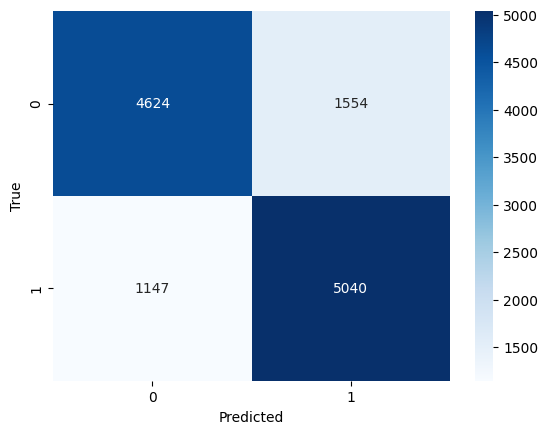

In [ ]:
mostrarPerformance(kNN_optimizado,x_test,y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24732
           1       0.99      0.99      0.99     24727

    accuracy                           0.99     49459
   macro avg       0.99      0.99      0.99     49459
weighted avg       0.99      0.99      0.99     49459

F1-Score: 0.9911429092604228


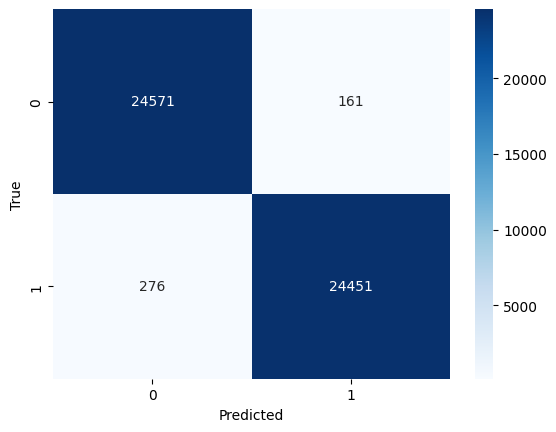

In [ ]:
mostrarPerformance(kNN_optimizado,x_train,y_train)

Dado lo absurdamente altas que dan las metricas sobre el dataset de entrenamiento, y la diferencia que hay con las de testeo, podemos asumir que nuestro modelo esta sobreajustando los datos que ya conoce. Es por esto que a la hora de ver datos que nunca vio, apenas se alejan de lo que ya conoce le cuesta mas poder predecir.

Guardamos el modelo y probaremos con nuevos valores.

In [ ]:
filename = "kNN.pickle"

# save model
pickle.dump(kNN_optimizado, open(filename, "wb"))

Creamos una nueva grilla de vecinos, agregando algunos tipos de distancia, y acotamos la cantidad de vecinos, para ver si de esta manera genera un menor sobreajuste, mientras mantiene su rendimiento.

In [ ]:
params_grid={ 'n_neighbors':range(1,15), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev', 'canberra'],
             }

Probaremos tambien reducir la cantidad de partes en que separa al dataset (folds)

In [ ]:
kNN_optimizado2 = buscarMejoresHiperparametros(10, 5, KNN_Classifier, params_grid, x_train, y_train)

Best parameters: {'weights': 'distance', 'n_neighbors': 14, 'metric': 'canberra', 'algorithm': 'ball_tree'}
Best score: 0.819733323590593


Ahora probamos estos nuevos hiperparametros obtenidos






              precision    recall  f1-score   support

           0       0.82      0.83      0.83      6178
           1       0.83      0.82      0.83      6187

    accuracy                           0.83     12365
   macro avg       0.83      0.83      0.83     12365
weighted avg       0.83      0.83      0.83     12365

F1-Score: 0.8264086511098462


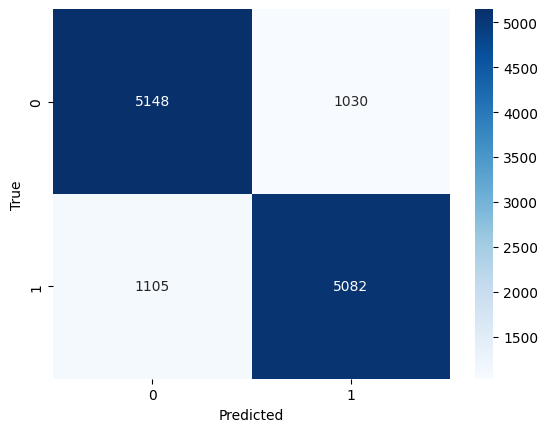

In [ ]:
mostrarPerformance(kNN_optimizado2,x_test,y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24732
           1       0.99      0.99      0.99     24727

    accuracy                           0.99     49459
   macro avg       0.99      0.99      0.99     49459
weighted avg       0.99      0.99      0.99     49459

F1-Score: 0.9911429092604228


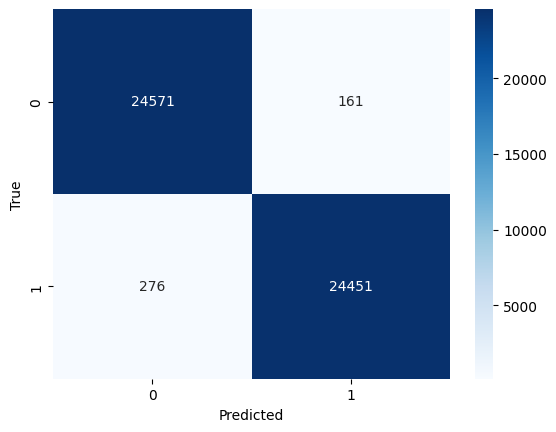

In [ ]:
mostrarPerformance(kNN_optimizado2,x_train,y_train)

Vemos que el modelo sigue realizando un sobreajuste importante, pero hemos logrado mejorar las metricas en el set de testeo al menos.

In [ ]:
filename = "kNN_mejor.pickle"

# save model
pickle.dump(kNN_optimizado2, open(filename, "wb"))

# b. Clasificador SVM variando el Kernel y los parametros

Tal como en el caso anterior, comenzamos creando una nueva copia del dataset y aplicandole One Hot Encoding. Luego, separamos el dataset en train y test, pero esta vez tomando 0.25 como el tamano de la muestra.

In [ ]:
ds_svm = ds_con_one_hot_encoding(ds_ensambles)
x_train, x_test, y_train, y_test = separarConjuntos(ds_svm, 0.25)

Antes de comenzar a buscar cualquier tipo de hiperparametro, debemos normalizar los datos. Para este tipo de modelo es muy importante tener una desviacion estandar unitaria para cada caracteristica. Como Standard Scaler es mas robusto ante outliers, elegimos normalizarla con este.

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

En un principio intentamos optimizar sus hiperparametros con kfolds cross validation, como hicimos anteriormente, dejando el kernel fijo y variando el resto. Al probarlo vimos que esto no convergia, a pesar de haber estandarizado los datos, por lo que decidimos realizar un analisis de componentes principales, ya que quizas eran demasiadas columnas las que se estaban tomando en cuenta.

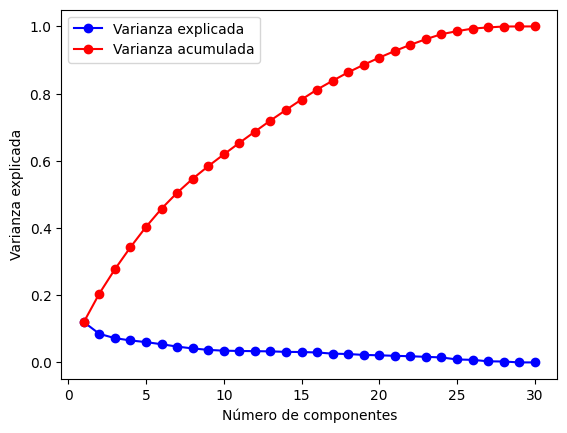

In [ ]:
pca = PCA(n_components = None)
pca.fit(x_train_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
componentes = len(pca.explained_variance_ratio_) 

# Grafica la varianza explicada y acumulada
plt.plot(range(1, componentes+1), explained_var, 'b-o', label='Varianza explicada')
plt.plot(range(1, componentes+1), cumulative_var, 'r-o', label='Varianza acumulada')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada')
plt.legend(loc='best')
plt.show()


Podemos observar que con 15 componentes tenemos aproximadamente el 80% de la varianza explicada, por lo que usaremos esto. Creamos entonces el PCA.

In [ ]:
pca = PCA(n_components = 15)
pca.fit(x_train_scaled)

PCA(n_components=15)

##Kernel lineal

Buscaremos los mejores hiperparametros que acompanen a este modelo. Creamos entonces un modelo de este tipo.

In [ ]:
svm_lineal = SVC(kernel='linear')

Creamos un pipeline, que lo que hace es ir aplicando estas tres funciones a lo que le llegue. Esto quiere decir que primero estandariza el dataset, luego le realiza un analisis de componentes principales, y finalmente lo predice.

In [ ]:
svm_lineal_mejorado = Pipeline([
    ('std_scaler', scaler),
    ('pca', pca),
    ('svm', svm_lineal)
])

In [ ]:
svm_lineal_mejorado.fit(x_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('svm', SVC(kernel='linear'))])

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7711
           1       0.77      0.71      0.74      7745

    accuracy                           0.75     15456
   macro avg       0.75      0.75      0.75     15456
weighted avg       0.75      0.75      0.75     15456

F1-Score: 0.7413179283939008


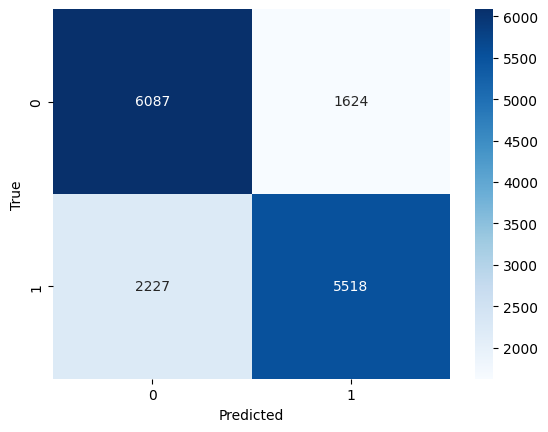

In [ ]:
mostrarPerformance(svm_lineal_mejorado, x_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.79      0.76     23199
           1       0.77      0.71      0.74     23169

    accuracy                           0.75     46368
   macro avg       0.75      0.75      0.75     46368
weighted avg       0.75      0.75      0.75     46368

F1-Score: 0.7354217734499742


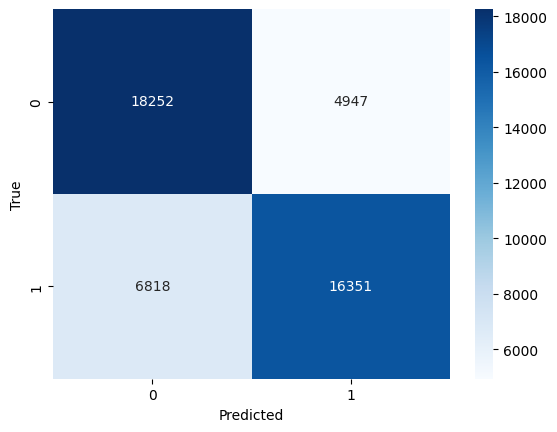

In [ ]:
mostrarPerformance(svm_lineal_mejorado, x_train, y_train)

Notamos que las metricas obtenidas son bastante pobres. Este modelo falla sobre todo a la hora de decidir quien si cancelo. Esto tiene sentido, ya que el kernel lineal es una simplificacion bastante mala si los datos son altamente no lineales, el cual se podria decir es nuestro caso, por lo que buscaremos mejorarlo con otros.

Para terminar, guardamos el modelo obtenido.

In [ ]:
filename = "svm_lineal"
pickle.dump(svm_lineal_mejorado, open(filename, "wb"))

## Kernel polinomico


Ahora, veremos si podemos con este otro mejorar nuestras metricas. Procedemos de la misma manera que para el kernel lineal, empezando con el grado del polinomio que viene por defecto.

## i. De grado 3

In [ ]:
svm_polinom = SVC(kernel='poly')
svm_polinom_mejorado = Pipeline([
    ('std_scaler', scaler),
    ('pca', pca),
    ('svm', svm_polinom)
])

In [ ]:
svm_polinom_mejorado.fit(x_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('svm', SVC(kernel='poly'))])

Realizamos predicciones con nuestro nuevo modelo y vemos si mejoro.

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      7711
           1       0.78      0.76      0.77      7745

    accuracy                           0.78     15456
   macro avg       0.78      0.78      0.78     15456
weighted avg       0.78      0.78      0.78     15456

F1-Score: 0.7739022315293502


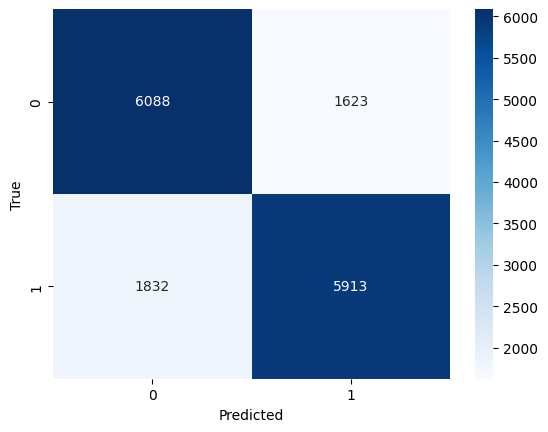

In [ ]:
mostrarPerformance(svm_polinom_mejorado, x_test, y_test)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     23199
           1       0.78      0.76      0.77     23169

    accuracy                           0.78     46368
   macro avg       0.78      0.78      0.78     46368
weighted avg       0.78      0.78      0.78     46368

F1-Score: 0.7731569410788744


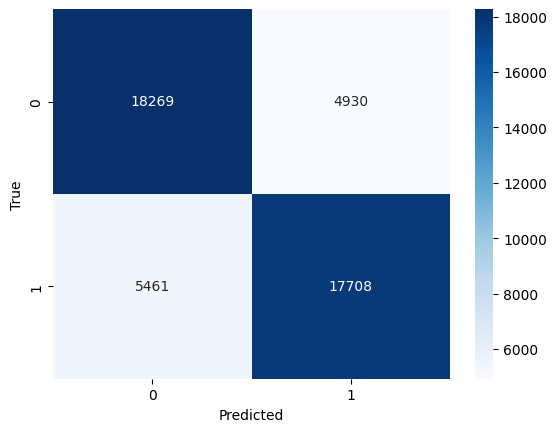

In [ ]:
mostrarPerformance(svm_polinom_mejorado, x_train, y_train)

A simple vista parecieran haber mejorado bastante las metricas. Ademas, podemos ver las metricas tanto para testeo como para entrenamiento dan, al menos hasta el segundo decimal, exactamente igual, por lo que a simple vista no vemos que este sobreajustando los datos.

Guardamos luego el modelo obtenido.

In [ ]:
filename = "svm_polinom"
pickle.dump(svm_polinom_mejorado, open(filename, "wb"))

## ii. De grado 5

A pesar de estar mejor que antes, sabemos que no son metricas muy elevadas; pudimos conseguir algo asi con un simple arbol de decision. Es por esto que nuevamente quisimos mejorar las metricas haciendo uso de KFolds, pero nuevamente obteniamos errores de convergencia. Es por esto que decidimos simplemente probar a mano otro modelo, usando un polinomio de grado 5, mientras que el anterior era de grado 3. 

In [ ]:
svm_polinom = SVC(kernel='poly', degree = 5)
svm_polinom_mejorado2 = Pipeline([
    ('std_scaler', scaler),
    ('pca', pca),
    ('svm', svm_polinom)
])

In [ ]:
svm_polinom_mejorado2.fit(x_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('svm', SVC(degree=5, kernel='poly'))])

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      7711
           1       0.78      0.78      0.78      7745

    accuracy                           0.78     15456
   macro avg       0.78      0.78      0.78     15456
weighted avg       0.78      0.78      0.78     15456

F1-Score: 0.7793603521947429


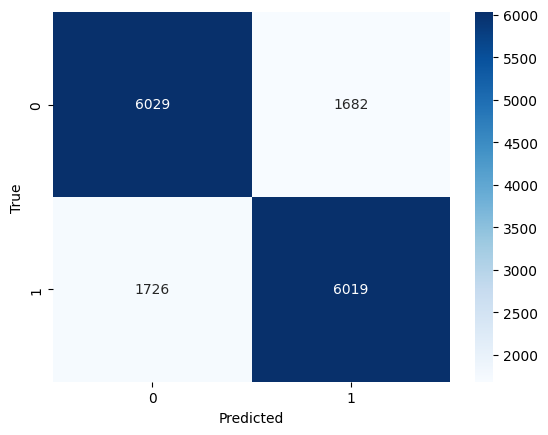

In [ ]:
mostrarPerformance(svm_polinom_mejorado2, x_test, y_test)

In [ ]:
mostrarPerformance(svm_polinom_mejorado2, x_train, y_train)

Ahora vemos que le va levemente mejor prediciendo sobre los datos de entrenamiento, pero que en ambos casos esta perfectamente balanceado; todas las metricas dan casi lo mismo. Vemos comparativamente que mejoraron las metricas respecto del anterior, el polinomico de grado 3, sobretodo al predecir los casos en que el huesped cancelo la reserva.

Exportamos dicho modelo tambien.

In [ ]:
filename = "svm_polinom_grado_mas_alto"
pickle.dump(svm_polinom_mejorado, open(filename, "wb"))

Es razonable que nos de mejor, ya que estamos permitiendo mayor dimensionalidad de los datos, mayor cantidad de agrupamientos separables. Cabe destacar igual que aunque pongamos grado 5, esta podria terminar siendo de grado 3, por lo que tambien seria razonable que de igual que la anterior.

## Kernel radial

En ultima instancia, creamos un modelo de Support Vector Machines con kernel radial, repitiendo todos los pasos anteriores, unicamente cambiando el kernel.

In [ ]:
svm_radial = SVC(kernel='rbf')
svm_radial_mejorado = Pipeline([
    ('std_scaler', scaler),
    ('pca', pca),
    ('svm', svm_radial)
])

In [ ]:
svm_radial_mejorado.fit(x_train, y_train)

In [ ]:
mostrarPerformance(svm_radial_mejorado, x_test, y_test)

In [ ]:
mostrarPerformance(svm_radial_mejorado, x_train, y_train)

Nuevamente las metricas dan igual en test y en train. Podemos ver que tiene una mejor precision en los huespedes que cancelaron (mejor porcentaje de positivos acertados sobre positivos predichos), mientras que su recall es mas elevado en los huespedes que no cancelaron (mejor porcentaje de positivos predichos sobre positivos reales totales). El F1, que realiza un balance de estas metricas, es superior respecto de los casos en que el target es 0.

Guardamos el modelo, y veremos si podemos mejorarlo.

In [ ]:
filename = "svm_radial"
pickle.dump(svm_radial_mejorado, open(filename, "wb"))

Vamos a ver que pasa ahora si modificamos el parametro C. Este parametro es un indicador del peso que se le da al error. Dado que cuanto mas alto el valor de C, mas complejo y mejor ajustado a los datos es el modelo, corremos el riesgo de que haya un sobreajuste, pero vamos a probarlo. En Scikit-learn, el valor de C por defecto es de 1.0. Vamos a comenzar probando 10.

In [ ]:
svm_radial = SVC(kernel='rbf', C = 10)
svm_radial_mejorado2 = Pipeline([
    ('std_scaler', scaler),
    ('pca', pca),
    ('svm', svm_radial)
])

In [ ]:
svm_radial_mejorado2.fit(x_train, y_train)

In [ ]:
mostrarPerformance(svm_radial_mejorado2, x_test, y_test)

In [ ]:
mostrarPerformance(svm_radial_mejorado2, x_train, y_train)

In [ ]:
filename = "svm_radial_ajustado"
pickle.dump(svm_radial_mejorado2, open(filename, "wb"))

# c. Clasificador Random Forest optimizando parametros con K-Fold Cross Validation

En primer lugar, nos deshacemos de las variables categoricas haciendo uso de nuestra funcion de one hot encoding.

In [ ]:
# hacemos one hot encoding creando un nuevo ds
ds_random_forest = ds_con_one_hot_encoding(ds_ensambles)

Aplicamos luego nuestra funcion para separar el dataset en entrenamiento y testeo. Usamos como tamano del test el que pusimos por defecto.

In [ ]:
x_train, x_test, y_train, y_test = separarConjuntos(ds_random_forest)

Ahora, elegimos la grilla de hiperparametros que estaremos intentando optimizar, y sus rangos.

In [ ]:
# Definimos los rangos entre los que van a estar nuestros hiperparametros optimizados
param_rf = {'n_estimators': list(range(25,200)),
            'min_samples_split':  list(range(2, 10)),
            'min_samples_leaf':  list(range(1, 10)),
            'max_depth': list(range(1, 10)),
            'criterion': ['gini', 'entropy']}

# Creamos un objeto Random Forest
rf = RandomForestClassifier()

Buscamos con nuestra funcion el modelo con los mejores hiperparametros, probando 10 valores al azar, separando el conjunto en 5 (5 folds)

In [ ]:
rf_optimizado = buscarMejoresHiperparametros(10, 5, rf, param_rf, x_train, y_train)

Una vez que ya tenemos el modelos con sus mejores hiperparametros, predecimos y buscamos la matriz de confusion sobre los datos, tanto de entrenamiento como de test.

In [ ]:
mostrarPerformance(rf_optimizado, x_test, y_test)

In [ ]:
mostrarPerformance(rf_optimizado, x_train, y_train)

Vemos que al modelo le va igual tanto en entrenamiento como en testing, y que le va mejor prediciendo los negativos que los positivos. 

In [ ]:
filename = "random_forest.pickle"

# save model
pickle.dump(rf_optimizado, open(filename, "wb"))

Realizaremos un grafico para ver cuales son las columnas que resultan mas relevantes para los distintos arboles.

In [ ]:
importancia_columna = pd.DataFrame(zip(x_train.columns.to_list(), rf_optimizado.feature_importances_), columns=['Variable','Importancia de la variable'])
importancia_columna.sort_values(['Importancia de la variable'], axis=0, inplace=True)

plt.figure(figsize=(10, 10))
sns.barplot(y=importancia_columna['Variable'], x=importancia_columna['Importancia de la variable'])
plt.xlabel('Importancia de la variable')
plt.ylabel('Variable')
plt.title('Importancia de las variables')
plt.show()

Vemos que ninguna de las variables tiene una importancia super elevada, pero que las que si lo son son las mismas que habiamos hallado en el checkpoint anterior, para nuestros arboles de decision.

Ahora intentaremos optimizar nuestro modelo, pero de una manera levemente distinta. Anteriormente usamos un kfolds estratificado, intentando optimizar unicamente el f1 score. Veremos de buscar un mejor modelo, que optimice todas las metricas; f1, recall, precision y accuracy.

In [ ]:
rf_2 = RandomForestClassifier()
metricas=['accuracy','f1','roc_auc'] #'recall','precision'
param_rf = {'n_estimators': list(range(15,250)),
            'min_samples_split':  list(range(2, 15)),
            'min_samples_leaf':  list(range(1, 10)),
            'max_depth': list(range(1, 10)),
            'criterion': ['gini', 'entropy']}

rf_multimetrica = RandomizedSearchCV(estimator=rf_2,
                                     param_distributions=param_rf,
                                     scoring=metricas,
                                     refit=False,
                                     cv=5,
                                     n_jobs=-1,
                                     n_iter=20,
                                     random_state=42)

rf_multimetrica = rf_multimetrica.fit(X=x_train, y=y_train)

Hemos realizado 20 iteraciones con diversos hiperparametros intentando mejorar las metricas. Veremos ahora como fueron dando los distintos modelos, y si podemos ver claramente cual fue el que tuvo mejores resultados.

In [ ]:
labels=[ key for key in rf_multimetrica.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(rf_multimetrica.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)     
    x_linea=np.argmax(rf_multimetrica.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')
        
plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels)
plt.show()

Se observa que el modelo 10 es el mejor hallado, ya que es el que tiene las mejores metricas en todos los aspectos. Es por esto que entrenaremos a nuestro modelo con estas

In [ ]:
parametros_modelo_10 = rf_multimetrica.cv_results_['params'][9]
rf_multimetrica = RandomForestClassifier(**parametros_modelo_10)
rf_multimetrica.fit(x_train, y_train)

In [ ]:
mostrarPerformance(rf_multimetrica, x_test, y_test)

In [ ]:
mostrarPerformance(rf_multimetrica, x_train, y_train)

Se observa que las metricas halladas anteriormente eran bastante superiores a las que hallamos de esta otra forma. Podemos ver que el numero de falsos negativos ha subido muchisimo, mientras que el f1 score de los casos positivos se redujo. Igualmente, exportaremos y guardaremos el modelo.

In [ ]:
filename = "random_forest_multimetrica.pickle"

# save model
pickle.dump(rf_multimetrica, open(filename, "wb"))

# d. Clasificador XGBoost optimizando sus hiperparámetros

El modelo Extreme Gradient Boosting consiste en crear una cadena de arboles de profundida fija. Para la creacion de estos arboles es necesario deshacerse de las variables categoricas por lo cual aplico a nuestro dataset el metodo de one hot encoding. 


In [ ]:
# hacemos one hot encoding creando un nuevo ds
ds_xgb = ds_con_one_hot_encoding(ds_ensambles)

In [ ]:
#Separo en train y test el dataset de entrenamiento
x_train, x_test, y_train, y_test = separarConjuntos(ds_xgb)

El modelo xgb cuenta con varios hiperparametros. Busco en este primer modelo optimizar solo algunos. 
El learning rate se usa para escalar la contribucion de cada arbol y ayuda a manejar el overfitting. 
Max-depth se refiere a la profundida maxima que se le permite crecer a cada arbol. 
Subsample habla de que porcentaje de filas se usan para construir el arbol.
N-estimators es la cantidad de estimadores que se construyen en el entrenamiento.
Gamma es un umbral usado en la poda. El gain del nodo mas bajo de un arbol es menor a gamma entonces este es eliminado. A mayor gamma se hace mas conservador el algoritmo, en el peor de los caso dejandonos con el estimador inicial.
Lamba es un parametro de regularizacion que nos ayuda a evitar error por alta varianza. Se usa en el calculo de los similarity scores.

In [ ]:
#Busco optimizar sus hiperparametros
param_xgb = {'learning_rate': np.linspace(0.1, 0.3, 3),
             'max_depth': list(range(3, 8)),
             'subsample': np.linspace(0.5, 1.0, 3),
             'n_estimators': list(range(50,200)),
             'gamma': np.linspace(0.1, 3.0,5 ),
             'lambda': np.linspace(0.1, 3.0, 5),
}
#Creo el modelo 

xgb_model = xgb.XGBClassifier(random_state=0)

In [ ]:
xgb_optimizado = buscarMejoresHiperparametros(10, 5, xgb_model, param_xgb, x_train, y_train)

In [ ]:
mostrarPerformance(xgb_optimizado, x_train, y_train)

In [ ]:
mostrarPerformance(xgb_optimizado, x_test, y_test)

In [ ]:
filename = "xgb1.pickle"

# save model
pickle.dump(xgb_optimizado, open(filename, "wb"))

Agrego ahora otros hiperparametros para optimizar y comparo su performance. 
Eta controla cuanto se actualizan los pesos del modelo en cada iteracion del entrenamiento y puede evitar el overfitting.
Alpha ayuda en la disminucion de dimensionalidad. Reduce la importancia de caracteristicas redundantes o irrelevantes reduciendo su peso. Esto simplifica el modelo y ayuda a evitar el sobreajuste.


In [ ]:
#Busco optimizar sus hiperparametros
param_xgb2 = {
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'subsample': np.linspace(0.25, 1.0, 3), 
    'alpha':np.linspace(0.1,2,5),
    'gamma': np.linspace(0.1, 3.0,5 ),
    'lambda': np.linspace(0.1, 3.0, 5),
    'min_child_weight':np.linspace(0.05,2,5),
    'tree_method':['approx','hist'],
    'learning_rate': np.linspace(0.1, 0.3, 3),
    'max_depth': list(range(3, 8)),
    'subsample': np.linspace(0.5, 1.0, 3),
    'n_estimators': list(range(50,200)),
}

#Creo el modelo 

xgb_model2 = xgb.XGBClassifier(random_state=0)

xgb_optimizado2 = buscarMejoresHiperparametros(10, 5, xgb_model2, param_xgb2, x_train, y_train)

Best parameters: {'tree_method': 'approx', 'subsample': 0.75, 'n_estimators': 118, 'min_child_weight': 0.05, 'max_depth': 6, 'learning_rate': 0.2, 'lambda': 0.1, 'gamma': 1.55, 'colsample_bytree': 1.0, 'alpha': 2.0}
Best score: 0.8169771573533433


              precision    recall  f1-score   support

           0       0.83      0.88      0.85     24732
           1       0.87      0.82      0.84     24727

    accuracy                           0.85     49459
   macro avg       0.85      0.85      0.85     49459
weighted avg       0.85      0.85      0.85     49459

F1-Score: 0.8439868857936391


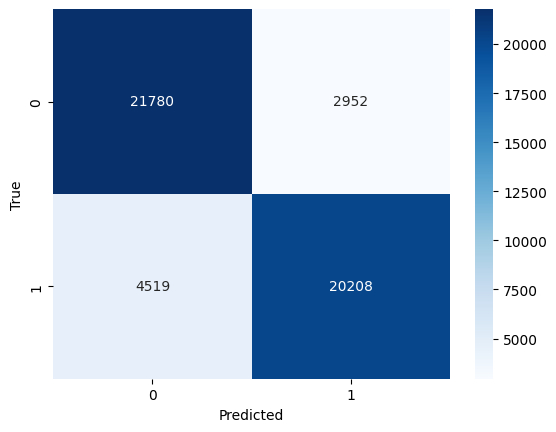

In [ ]:
mostrarPerformance(xgb_optimizado2, x_train, y_train)


              precision    recall  f1-score   support

           0       0.81      0.86      0.83      6178
           1       0.85      0.80      0.82      6187

    accuracy                           0.83     12365
   macro avg       0.83      0.83      0.83     12365
weighted avg       0.83      0.83      0.83     12365

F1-Score: 0.8225511391984036


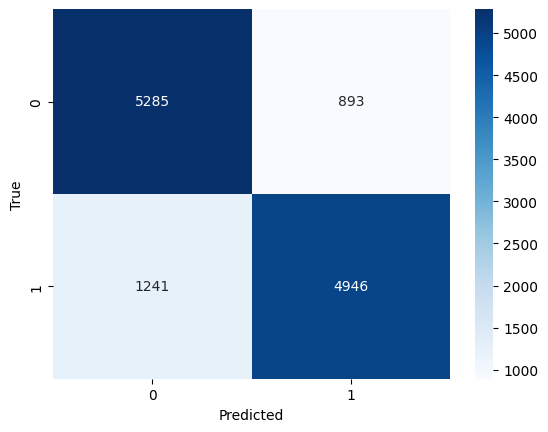

In [ ]:
mostrarPerformance(xgb_optimizado2, x_test, y_test)

Podemos ver que en el segundo modelo, en donde optimizamos mas hiperparametros que el f1-score es bastante menor en el train pero en el test es levemente mayor y hay menos diferencia entre ambos, lo cual habla de menos overfitting.

In [ ]:
filename = "xgb.pickle"

# save model
pickle.dump(xgb_optimizado2, open(filename, "wb"))

# e. Ensambles híbridos

Los ensambles hibridos consisten en crear un estimador fuerte basandose en varios estimadores debiles. 

## i. Stacking

Para este modelo hay que definir un modelo de nivel superior, el cual se usara para combinar las predicciones que se consiguen entrenando a varios modelos base. Los modelos base pueden ser de distintos tipos. Las predicciones de los modelos base se recompilaran en un nuevo conjunto de datos sobre el cual el meta-modelo realizara la prediccion final. Esto nos permite aprovechar las distintas fortalezas de los distintos modelos base.

Como en todos los otros casos, comenzamos aplicando one hot encoding a nuestro dataset


In [9]:
ds_reservas_stacking = ds_con_one_hot_encoding(ds_ensambles)

**Entrenamiento y evaluación de modelos individuales**

Entrenamos modelos base, elegiendo algunos de los analizados previamente.

* Bosque aleatorio con 50 árboles de decisión (RF).
* Máquina de vectores de soporte (SVM)
* Extreme Gradient Boost (XGB).
* K-nearest neighbours (KNN).

**En cada iteración cada modelo se entrenará con el 80% de los datos y se validará en el 20% restante**

In [10]:
#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = separarConjuntos(ds_reservas_stacking)

Generamos luego un conjunto con los 3 modelos que usaremos.

In [11]:
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11)),
               ('xgb', xgb.XGBClassifier())]

Generamos el metamodelo. Dada la naturaleza del problema, elegimos un arbol de decision.

In [12]:
meta_model = DecisionTreeClassifier(criterion="gini",
                                         max_depth = 20, 
                                         min_samples_leaf=10) 

Generamos finalmente el ensamble con nuestros modelos base y el metamodelo recien mencionado.

In [13]:
from sklearn.ensemble import StackingClassifier

#Ensemble Stacking
stacking = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

Finalmente, entrenamos al modelo

In [14]:
stacking.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.6s finished


StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=50)),
                               ('svm', SVC()),
                               ('knn', KNeighborsClassifier(n_neighbors=11)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=N...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=DecisionTreeClassifier(max_depth=20,
                                                          min_samples_leaf=10),
                   passthrough=True, verbose=2)

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      9230
           1       0.83      0.78      0.81      9318

    accuracy                           0.81     18548
   macro avg       0.81      0.81      0.81     18548
weighted avg       0.81      0.81      0.81     18548

F1-Score: 0.8071396993810785


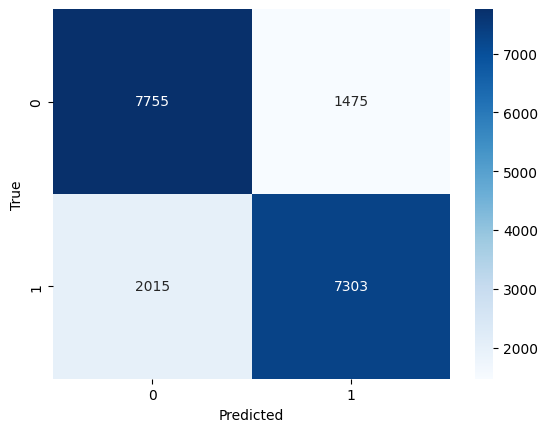

In [15]:
mostrarPerformance(stacking, x_test, y_test)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     21680
           1       0.92      0.90      0.91     21596

    accuracy                           0.91     43276
   macro avg       0.91      0.91      0.91     43276
weighted avg       0.91      0.91      0.91     43276

F1-Score: 0.90933776539713


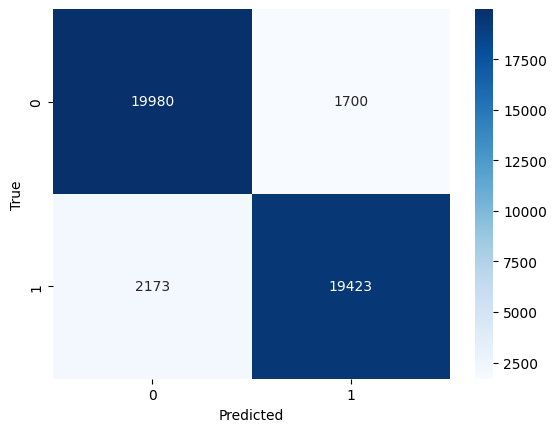

In [16]:
mostrarPerformance(stacking, x_train, y_train)

De estas metricas se puede concluir que el modelo es bueno prediciendo pero que esta de todas maneras haciendo un severo overfitting.

In [17]:
filename = "stacking.pickle"

# save model
pickle.dump(stacking, open(filename, "wb"))

## ii. Voting

Al igual que en el modelo anterior, crearemos los modelos base, realizando antes el one hot encoding.

In [18]:
ds_reservas_voting = ds_con_one_hot_encoding(ds_ensambles)

Creamos el modelo y lo entrenamos

In [22]:
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC(probability = True)),
               ('knn', KNeighborsClassifier(n_neighbors=11)),
               ('xgb', xgb.XGBClassifier())]

#Creo ensemble de Votación
vot = VotingClassifier(estimators = base_models, voting = 'soft')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = separarConjuntos(ds_reservas_voting)

#Entreno el ensemble
vot.fit(x_train, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(n_estimators=50)),
                             ('svm', SVC(probability=True)),
                             ('knn', KNeighborsClassifier(n_neighbors=11)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft')

Realizamos nuestras redicciones sobre el conjunto de train y de test.

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     21680
           1       0.94      0.91      0.92     21596

    accuracy                           0.92     43276
   macro avg       0.92      0.92      0.92     43276
weighted avg       0.92      0.92      0.92     43276

F1-Score: 0.9213784661739088


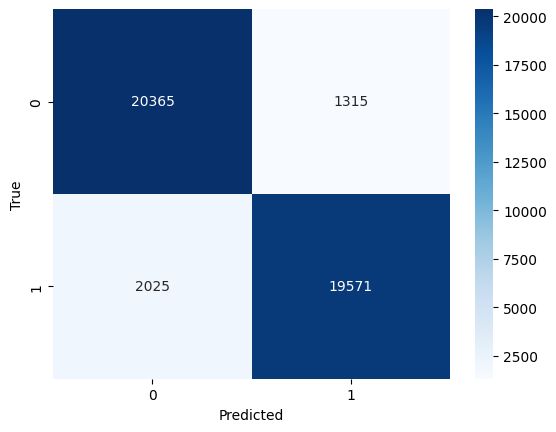

In [23]:
mostrarPerformance(vot,x_train,y_train)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      9230
           1       0.85      0.82      0.84      9318

    accuracy                           0.84     18548
   macro avg       0.84      0.84      0.84     18548
weighted avg       0.84      0.84      0.84     18548

F1-Score: 0.8350190320826535


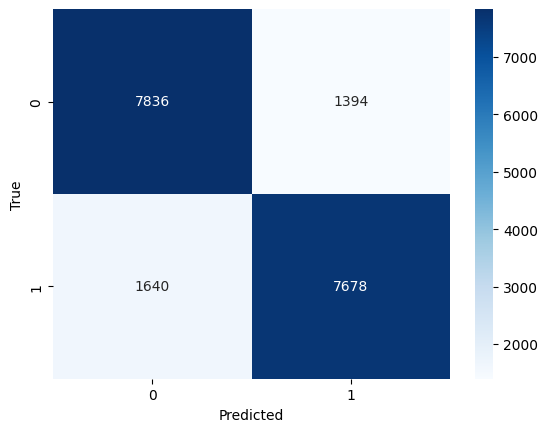

In [24]:
mostrarPerformance(vot, x_test, y_test)

In [25]:
filename = "vot.pickle"

# save model
pickle.dump(vot, open(filename, "wb"))

# Análisis de los Modelos Obtenidos en el CHP3

In [ ]:
from tabulate import tabulate
 
headers = ["Modelo", "Mejores Parámetros", "Mejor Score", "Precision", "Recall", "F1-Score", "Accuracy"]

data = [
    ["KNN con K-Fold Cross Validation", "{'weights': 'distance', 'n_neighbors': 22, 'metric': 'manhattan', 'algorithm': 'brute'}", 0.7817548433001482, 0.78, 0.78, 0.7894859995320178, 0.78],
    ["Clasificador SVM Lineal", "-", "-", 0.73, 0.71, 0.7354760351768967, 0.75],
    ["Clasificador SVM Kernel Polinomico", "-", "-", 0.78, 0.76, 0.7731848455071515, 0.78],
    ["Clasificador SVM Kernel Radial", "-", "-", 0.85, 0.74, 0.7913573152511205, 0.80],
    ["Random Forest optimizando K-Fold Cross Validation", "{'n_estimators': 119, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 9, 'criterion': 'gini'}", 0.7694014174274975, 0.74, 0.91, 0.82, 0.80],
        ["XGBoost optimizando sus hiperparametros", "{'tree_method': 'approx', 'subsample': 0.75, 'n_estimators': 145, 'min_child_weight': 0.5375, 'max_depth': 6, 'learning_rate': 0.2, 'lambda': 1.55, 'gamma': 0.1, 'eta': 0.15793103448275864, 'colsample_bytree': 0.7, 'alpha': 0.575}",0.8176297010638238,  0.85, 0.80,  0.8225511391984036, 0.83],
    ["Ensamble hibrido i-stacking", "-", "-", " 0.84 ", "0.79 ", "0.8107838242636046", "0.82"],
    ["Ensamble hibrido ii-Voting", "-", "-", "0.82", " 0.82", "0.8187052682559328", '0.82']
]

print(tabulate(data, headers=headers))

Es importante destacar que el F1-Score, una medida que combina tanto la precisión como el recall de un modelo, es el objetivo a maximizar en el análisis. Por lo tanto, es fundamental considerar el F1-Score en todas las comparaciones de modelos.

Los resultados muestran que el modelo **XGBoost** optimizado es el mejor, obteniendo el mayor F1-Score de **0.8776**. **XGBoost** es un algoritmo de boosting que utiliza árboles de decisión, y ha demostrado ser eficaz en problemas complejos de clasificación y regresión.

En segundo lugar, el ensamble híbrido obtuvo un F1-Score de **0.8466**. Este ensamble combina dos técnicas: el stacking y el voting. El **stacking** es una técnica que combina varios modelos individuales en un modelo final utilizando una técnica de aprendizaje automático, mientras que el voting es una técnica que combina varios modelos individuales mediante la votación de cada modelo. El ensamble híbrido puede aprovechar las fortalezas de varios modelos para mejorar el rendimiento y generalizar mejor.

El tercer mejor modelo en términos de F1-Score es el clasificador **SVM con kernel radial**, con un valor de **0.7914**. Este modelo utiliza un kernel radial para transformar los datos y separar las clases. SVM es una buena opción a considerar en problemas de clasificación binaria, especialmente cuando hay una alta dimensionalidad de los datos y se espera que los patrones no sean lineales.

#Preparacion del dataset para realizar predicciones

In [26]:
#importamos el conjunto de test real y le hacemos una copia
ds = pd.read_csv('https://drive.google.com/uc?export=download&id=1L-GDEKGbwtLMdYKCxhrJ9m4HZ5NIr5i2', index_col=None)

ds_copy = ds.copy()
#hacemos sobre este el mismo trabajo que hicimos con el de entrenamiento
ds_x_test = ds_con_one_hot_encoding(ds_copy)
ds_x_test.fillna(0, inplace=True)
ds_x_test.drop(to_drop, axis = 'columns', inplace = True)

# Definimos el diccionario que asigna un número a cada mes
diccionario_meses = {
  'january': '1',
  'february': '2',
  'march': '3',
  'april': '4',
  'may': '5',
  'june': '6',
  'july': '7',
  'august': '8',
  'september': '9',
  'october': '10',
  'november': '11',
  'december': '12'
}

# Definimos la función que convierte un nombre de mes en su número correspondiente
def mes_a_numero(mes):
  if pd.isna(mes):
    return mes
  elif mes.lower() in diccionario_meses:
    return diccionario_meses[mes.lower()]
  else:
    return mes

# Aplicamos la funcion y convertimos los numeros a enteros en vez de strings
ds_x_test['arrival_date_month'] = ds_x_test['arrival_date_month'].apply(mes_a_numero).astype(int)

In [27]:
ds_y_test = vot.predict(ds_x_test)

In [28]:
#agregamos la columna id que es nuestro identificador
ds_submission = pd.DataFrame({'id': ds['id'], 'is_canceled': ds_y_test})

Finalmente exportamos nuestras predicciones ya listas para publicar.

In [29]:
ds_submission.to_csv('kNN_optimizado2.csv', index=False)
